## SO - Laboratorio de Escalonamento ##

Neste laboratório, iremos simular o funcionamento de algoritmos de escalonamento básicos para entender melhor seu funcionamento.

Alunas: 
- Brenda Aguiar
- Jessica Brito

In [93]:
import numpy as np
import random
import matplotlib.pyplot as plt

Na célula abaixo, temos uma classe Processo, que tem as informações de execução:

In [2]:
class Processo(object):
    def __init__(self,pnome,pio,ptam,prioridade,tempoChegada, estadoProc=0):
        self.nome = pnome
        self.io = pio # Probabilidade de fazer E/S, inicialmente zero
        self.tam = ptam # Quantos Timeslices sao necessarios para terminar
        self.prio = prioridade # Prioridade, eh desnecessaria aora
        self.chegada = tempoChegada # Tempo de chegada
        
        self.estado = estadoProc # estados do processo
        self.tempoResposta = None # Tempo de Resposta do Processo
        self.tempoExecucao = None # Tempo de execução do processo

    def roda(self,quantum=None): # se rodar sem quantum, o processor roda ate o fim        
        if(random.randint(1,100)<self.io): #Verifica se fez E/S
            self.tam-=1
            self.estado = 3
            print(self.nome," fez e/s, falta ",self.tam)
            return 1, True #True que fez E/S
            
        if(quantum is None or self.tam<quantum):
            quantum = self.tam
            
        self.tam -=quantum
        print(self.nome," rodou por ",quantum," timeslice, faltam ",self.tam)
        if (self.tam == 0):
            self.estado = 4
        return quantum, False # False se nao fez E/S

E uma classe de escalonamento:

In [3]:
class escalonador(object):
    def __init__(self,vprontos=[]):
        self.prontos = vprontos 
        self.temposExecucao = []
        self.temposResposta = []

    def pronto(self,processo):
        pass
        
    def proximo(self):
        if len(self.prontos) > 0:
            return self.prontos[0]
        else:
            return None
        
    def feito(self):
        del(self.prontos[0])
        
    def turnaround(self):
        return np.mean(self.temposExecucao)
    
    def tempoRespostaMedio(self):
        return np.mean(self.temposResposta)
    
    def addTempoResposta(self, tempo):
        self.temposResposta.append(tempo)
    
    def addTempoExecucao(self, tempo):
        self.temposExecucao.append(tempo)

### Laboratório: ###


1 - Altere o simulador acima para calcular o tempo de execucao medio e tempo de resposta 

2 - Implemente o escalonador por FIFO e SJF e verifique seus tempos de execução e espera.

3 - Faça em outra célula uma implementação do STCF e Round Robin, alterando o p.roda() para receber o quantum


FIFO

In [4]:
class FIFO(escalonador):    
    def __init__(self,vprontos=[]):
        super().__init__(vprontos)
        
    def pronto(self,processo):
        processo.estado = 1
        self.prontos.append(processo)

SJF

In [5]:
class SJF(escalonador):    
    def __init__(self,vprontos=[]):
        super().__init__(vprontos)
        
    def pronto(self,processo):
        processo.estado = 1
        for i in range(len(self.prontos)):
            if self.prontos[i].tam > processo.tam:
                self.prontos.insert(i,processo)
                return

Round Robin

In [6]:
class RoundRobin(escalonador): 
    def __init__(self,vprontos=[]):
        super().__init__(vprontos)
        if (vprontos == []):
            self.atual = 0
        else:
            self.atual = -1
        
    def pronto(self,processo):
        processo.estado = 1
        self.prontos.append(processo)
        
    def proximo(self):
        try:
            self.atual+=1
            proc = self.prontos[self.atual]
        except:
            self.atual = 0
            proc = self.prontos[self.atual]
        return proc
        
    def done(self):
        del(self.prontos[self.atual])
        try:
            self.atual-=1
            self.prontos[self.atual]
        except:
            self.atual = 0

In [7]:
def chamaEscalonador(nomeEscalonador, procs, quantum=None, tempoBloq=2):
    # Escolhe o escalonador
    if (nomeEscalonador == "fifo"):
        escalonador = FIFO(procs) #troque escalonador pelo seu escalonador
    elif (nomeEscalonador == "sjf"):
        escalonador = SJF(procs) #troque escalonador pelo seu escalonador
    elif (nomeEscalonador == "stcf"):
        escalonador = SJF(procs) #troque escalonador pelo seu escalonador
        quantum = 1
    else:
        escalonador = RoundRobin(procs) #troque escalonador pelo seu escalonador
    return escalonador, nomeEscalonador, quantum

In [8]:
def rodaEscalonador(escalonador, nomeEscalonador, quantum):
    bloqueados = []
    tempo = 0
    random.seed(0)
    
    print(f'################# {nomeEscalonador.upper()} ######################')
    while len(escalonador.prontos) > 0:
        p = escalonador.proximo()
        if (p is not None):
            rodou, _ = p.roda(quantum) #adicione quantum como parâmetro, por enquanto nao temos E/S
            if(p.estado == 0):
                escalonador.pronto(p)
            elif (p.tempoResposta == None):
                p.tempoResposta = tempo - p.chegada
                escalonador.addTempoResposta(p.tempoResposta)
                print(f'| Tempo de Resposta({p.nome}) = {p.tempoResposta} |')
            tempo+=rodou

            if (p.estado == 4) :
                p.tempoExecucao = tempo - p.chegada
                escalonador.addTempoExecucao(p.tempoExecucao)
                print(f'| Tempo de Execução({p.nome}) = {p.tempoExecucao} | \n')
                escalonador.feito()
        else:
            #Reduz o tempo de todos os bloqueados em uma unidade se nao havia ninguem pronto
            print(" > +1 timeslice")
            tempo+=1
        print('-------------------------------------------')
    print(f'Turnaround = {escalonador.turnaround()}')
    print(f'Tempo de resposta Medio = {escalonador.tempoRespostaMedio()}')
    return escalonador.turnaround(), escalonador.tempoRespostaMedio()

In [72]:
def escalonar(nomeEscalonador, procs, quantum=None, tempoBloq=2):
    esc, nomeEsc, quantum = chamaEscalonador(nomeEscalonador, procs, quantum, tempoBloq=2)
    turnaround, rm = rodaEscalonador(esc, nomeEsc, quantum)
    return rm

In [57]:
def chamaProcs(nprocs, nomes, chanceio, tamanho):
    total = tamanho.sum()
    procs = []
    for i in range(nprocs):
        procs.append(Processo(nomes[i],chanceio[i],tamanho[i],0,0,1)) #cria uma lista procs de Processos
    return procs

## Questionário de Escalonamento 1.1 ##

### Questão 1 e 3 ###
Dado um workload de 5 processos de tamanho 20, calcule o tempo de execução e de resposta do escalonador FIFO:

In [58]:
procs = chamaProcs(5, ['A','B','C','D','E'], [0,0,0,0,0], np.array([20,20,20,20,20]))

escalonar("fifo", procs)

################# FIFO ######################
A  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(A) = 0 |
| Tempo de Execução(A) = 20 | 

-------------------------------------------
B  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(B) = 20 |
| Tempo de Execução(B) = 40 | 

-------------------------------------------
C  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(C) = 40 |
| Tempo de Execução(C) = 60 | 

-------------------------------------------
D  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(D) = 60 |
| Tempo de Execução(D) = 80 | 

-------------------------------------------
E  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(E) = 80 |
| Tempo de Execução(E) = 100 | 

-------------------------------------------
Turnaround = 60.0
Tempo de resposta Medio = 40.0


(60.0, 40.0)

### Questão 2 e 4 ###
Dado um workload de 5 processos de tamanho 20, calcule o tempo de execução e de resposta do escalonador SJF:

In [59]:
procs = chamaProcs(5, ['A','B','C','D','E'], [0,0,0,0,0], np.array([20,20,20,20,20]))

escalonar("sjf", procs)

################# SJF ######################
A  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(A) = 0 |
| Tempo de Execução(A) = 20 | 

-------------------------------------------
B  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(B) = 20 |
| Tempo de Execução(B) = 40 | 

-------------------------------------------
C  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(C) = 40 |
| Tempo de Execução(C) = 60 | 

-------------------------------------------
D  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(D) = 60 |
| Tempo de Execução(D) = 80 | 

-------------------------------------------
E  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(E) = 80 |
| Tempo de Execução(E) = 100 | 

-------------------------------------------
Turnaround = 60.0
Tempo de resposta Medio = 40.0


(60.0, 40.0)

### Questão 5 e 6 ###
Dado um workload de 5 processos de tamanho 20, calcule o tempo de execução e resposta do escalonador Round Robin com quantum=2:

In [60]:
procs = chamaProcs(5, ['A','B','C','D','E'], [0,0,0,0,0], np.array([20,20,20,20,20]))

escalonar("round robin", procs, 2)

################# ROUND ROBIN ######################
A  rodou por  2  timeslice, faltam  18
| Tempo de Resposta(A) = 0 |
-------------------------------------------
B  rodou por  2  timeslice, faltam  18
| Tempo de Resposta(B) = 2 |
-------------------------------------------
C  rodou por  2  timeslice, faltam  18
| Tempo de Resposta(C) = 4 |
-------------------------------------------
D  rodou por  2  timeslice, faltam  18
| Tempo de Resposta(D) = 6 |
-------------------------------------------
E  rodou por  2  timeslice, faltam  18
| Tempo de Resposta(E) = 8 |
-------------------------------------------
A  rodou por  2  timeslice, faltam  16
-------------------------------------------
B  rodou por  2  timeslice, faltam  16
-------------------------------------------
C  rodou por  2  timeslice, faltam  16
-------------------------------------------
D  rodou por  2  timeslice, faltam  16
-------------------------------------------
E  rodou por  2  timeslice, faltam  16
----------------

(95.6, 4.0)

## Questionário de Escalonamento 1.2 ##

### Questão 1 e 2 ###
Dado um workload com 4 processos de tamanhos 10, 20, 30 e 40, qual o tempo de execução e de resposta do escalonador FIFO?

In [61]:
procs = chamaProcs(4, ['A','B','C','D'], [0,0,0,0], np.array([10,20,30,40]))

escalonar("fifo", procs)

################# FIFO ######################
A  rodou por  10  timeslice, faltam  0
| Tempo de Resposta(A) = 0 |
| Tempo de Execução(A) = 10 | 

-------------------------------------------
B  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(B) = 10 |
| Tempo de Execução(B) = 30 | 

-------------------------------------------
C  rodou por  30  timeslice, faltam  0
| Tempo de Resposta(C) = 30 |
| Tempo de Execução(C) = 60 | 

-------------------------------------------
D  rodou por  40  timeslice, faltam  0
| Tempo de Resposta(D) = 60 |
| Tempo de Execução(D) = 100 | 

-------------------------------------------
Turnaround = 50.0
Tempo de resposta Medio = 25.0


(50.0, 25.0)

### Questão 3 e 4 ###
Dado um workload com 4 processos de tamanhos 10, 20, 30 e 40, qual o tempo de execução e de resposta do escalonador SJF?

In [62]:
procs = chamaProcs(4, ['A','B','C','D'], [0,0,0,0], np.array([10,20,30,40]))

escalonar("sjf", procs)


################# SJF ######################
A  rodou por  10  timeslice, faltam  0
| Tempo de Resposta(A) = 0 |
| Tempo de Execução(A) = 10 | 

-------------------------------------------
B  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(B) = 10 |
| Tempo de Execução(B) = 30 | 

-------------------------------------------
C  rodou por  30  timeslice, faltam  0
| Tempo de Resposta(C) = 30 |
| Tempo de Execução(C) = 60 | 

-------------------------------------------
D  rodou por  40  timeslice, faltam  0
| Tempo de Resposta(D) = 60 |
| Tempo de Execução(D) = 100 | 

-------------------------------------------
Turnaround = 50.0
Tempo de resposta Medio = 25.0


(50.0, 25.0)

In [63]:
procs = chamaProcs(4, ['A','B','C','D'], [0,0,0,0], np.array([30,20,10,40]))
escalonar("stcf", procs)

################# STCF ######################
A  rodou por  1  timeslice, faltam  29
| Tempo de Resposta(A) = 0 |
-------------------------------------------
A  rodou por  1  timeslice, faltam  28
-------------------------------------------
A  rodou por  1  timeslice, faltam  27
-------------------------------------------
A  rodou por  1  timeslice, faltam  26
-------------------------------------------
A  rodou por  1  timeslice, faltam  25
-------------------------------------------
A  rodou por  1  timeslice, faltam  24
-------------------------------------------
A  rodou por  1  timeslice, faltam  23
-------------------------------------------
A  rodou por  1  timeslice, faltam  22
-------------------------------------------
A  rodou por  1  timeslice, faltam  21
-------------------------------------------
A  rodou por  1  timeslice, faltam  20
-------------------------------------------
A  rodou por  1  timeslice, faltam  19
-------------------------------------------
A  rodou por

(60.0, 35.0)

### Questão 5 e 6 ###
Dado um workload com 4 processos de tamanhos 10, 20, 30 e 40, qual o tempo de execução e de resposta do escalonador Round Robin com quantum=2?

In [64]:
procs = chamaProcs(4, ['A','B','C','D'], [0,0,0,0], np.array([10,20,30,40]))

escalonar("round robin", procs, 2)


################# ROUND ROBIN ######################
A  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(A) = 0 |
-------------------------------------------
B  rodou por  2  timeslice, faltam  18
| Tempo de Resposta(B) = 2 |
-------------------------------------------
C  rodou por  2  timeslice, faltam  28
| Tempo de Resposta(C) = 4 |
-------------------------------------------
D  rodou por  2  timeslice, faltam  38
| Tempo de Resposta(D) = 6 |
-------------------------------------------
A  rodou por  2  timeslice, faltam  6
-------------------------------------------
B  rodou por  2  timeslice, faltam  16
-------------------------------------------
C  rodou por  2  timeslice, faltam  26
-------------------------------------------
D  rodou por  2  timeslice, faltam  36
-------------------------------------------
A  rodou por  2  timeslice, faltam  4
-------------------------------------------
B  rodou por  2  timeslice, faltam  14
-------------------------------------------
C  r

(73.5, 3.0)

In [65]:
procs = chamaProcs(4, ['A','B','C','D'], [0,0,0,0], np.array([10,20,30,40]))
escalonar("sjf", procs, 1)

################# SJF ######################
A  rodou por  1  timeslice, faltam  9
| Tempo de Resposta(A) = 0 |
-------------------------------------------
A  rodou por  1  timeslice, faltam  8
-------------------------------------------
A  rodou por  1  timeslice, faltam  7
-------------------------------------------
A  rodou por  1  timeslice, faltam  6
-------------------------------------------
A  rodou por  1  timeslice, faltam  5
-------------------------------------------
A  rodou por  1  timeslice, faltam  4
-------------------------------------------
A  rodou por  1  timeslice, faltam  3
-------------------------------------------
A  rodou por  1  timeslice, faltam  2
-------------------------------------------
A  rodou por  1  timeslice, faltam  1
-------------------------------------------
A  rodou por  1  timeslice, faltam  0
| Tempo de Execução(A) = 10 | 

-------------------------------------------
B  rodou por  1  timeslice, faltam  19
| Tempo de Resposta(B) = 10 |
-----

(50.0, 25.0)

Na célula abaixo, temos uma simulação do funcionamento de um escalonador de processos. As duas configurações importantes aqui são o valor do quantum padrão (que pode ser dinamico em algoritmos mais complexos, e quantos timeslices um processo que faz e/s passa bloqueado.

Percebam que na terceira linha é instanciado o escalonador (neste caso, um round_robin). Isto foi feito assim para ser simples trocar o escalonador e repetir a simulação, bastando criar uma classe com os métodos pronto, proximo e construtor e alterar esta linha.

## Questionário de Escalonamento 1.3 ##

### Questão 4 ###
O que acontece com o tempo de resposta do SJF conforme o tamanho dos processos aumenta?

Faça no seu notebook um gráfico (recomendo o uso do matplotlib) relacionando tamanho médio dos processos com tempo de resposta, e chame de gráfico 1.


In [136]:

def graficoProcessos(tam, escalonador):
    #tam = 10 # tamanho dos processos
    tempoRespostas = np.array([0]*tam)
    tamanhosMedio = np.array([0]*tam)

    for i in range(tam):
        tamanho = tam*(i+1)
        tamanhosMedio[i] = tamanho
        tamanho = np.array([tamanho]*tam)
        procs = chamaProcs(4, ['A','B','C','D'], [0,0,0,0],  tamanho)
        tempoRespostas[i] = escalonar(escalonador, procs)
    return tempoRespostas, tamanhosMedio

In [137]:
tempoRespostas, tamanhosMedio = graficoProcessos(10, "sjf")

################# SJF ######################
A  rodou por  10  timeslice, faltam  0
| Tempo de Resposta(A) = 0 |
| Tempo de Execução(A) = 10 | 

-------------------------------------------
B  rodou por  10  timeslice, faltam  0
| Tempo de Resposta(B) = 10 |
| Tempo de Execução(B) = 20 | 

-------------------------------------------
C  rodou por  10  timeslice, faltam  0
| Tempo de Resposta(C) = 20 |
| Tempo de Execução(C) = 30 | 

-------------------------------------------
D  rodou por  10  timeslice, faltam  0
| Tempo de Resposta(D) = 30 |
| Tempo de Execução(D) = 40 | 

-------------------------------------------
Turnaround = 25.0
Tempo de resposta Medio = 15.0
################# SJF ######################
A  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(A) = 0 |
| Tempo de Execução(A) = 20 | 

-------------------------------------------
B  rodou por  20  timeslice, faltam  0
| Tempo de Resposta(B) = 20 |
| Tempo de Execução(B) = 40 | 

-------------------------------------

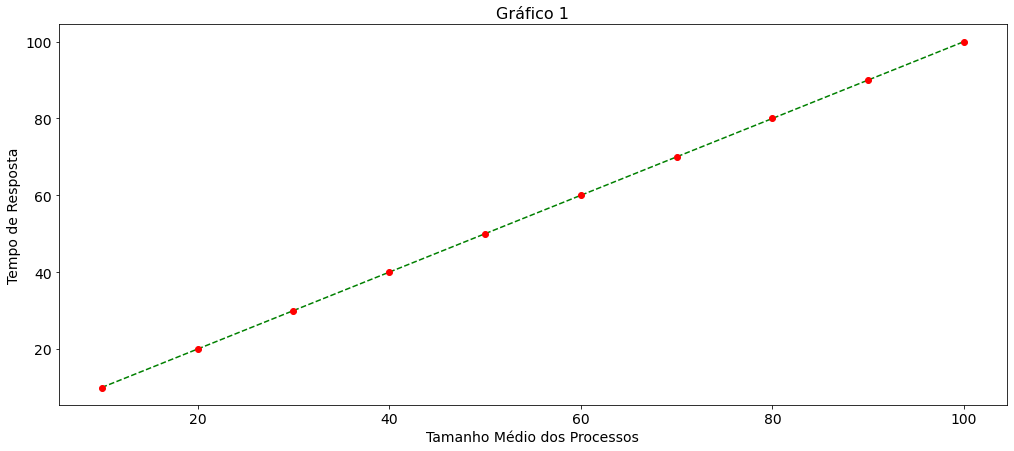

In [144]:
plt.figure(figsize=(17,7))

plt.title("Gráfico 1")
plt.ylabel("Tempo de Resposta")
plt.xlabel("Tamanho Médio dos Processos")
plt.plot(tamanhosMedio,tempoRespostas,'g--')
plt.plot(tamanhosMedio,tempoRespostas, 'ro')
plt.show()

### Questão 5 ###
O que acontece com o tempo de resposta do Round Robin conforme o quantum aumenta?

Faça um gráfico relacionando valor de quantum ao aumento do tempo de resposta.

Faça uma equação que calcule o pior tempo de resposta médio possível, dado N processos.

In [147]:
def graficoProcessosComQuantium(tam, escalonador):
    #tam = 10 # tamanho dos processos
    tempoRespostas = np.array([0]*tam)
    quantums = np.array([0]*tam)
    for i in range(tam):
        quantum = (i+1)
        quantums[i] = quantum
        tamanho = tam*(i+1)
        tamanhosMedio[i] = tamanho
        tamanho = np.array([tamanho]*tam)
        procs = chamaProcs(4, ['A','B','C','D'], [0,0,0,0],  tamanho)
        tempoRespostas[i] = escalonar(escalonador, procs, quantum)
    return quantums, tempoRespostas

In [148]:
quantums, tempoRespostas = graficoProcessosComQuantium(10, "round robin")

################# ROUND ROBIN ######################
A  rodou por  1  timeslice, faltam  9
| Tempo de Resposta(A) = 0 |
-------------------------------------------
B  rodou por  1  timeslice, faltam  9
| Tempo de Resposta(B) = 1 |
-------------------------------------------
C  rodou por  1  timeslice, faltam  9
| Tempo de Resposta(C) = 2 |
-------------------------------------------
D  rodou por  1  timeslice, faltam  9
| Tempo de Resposta(D) = 3 |
-------------------------------------------
A  rodou por  1  timeslice, faltam  8
-------------------------------------------
B  rodou por  1  timeslice, faltam  8
-------------------------------------------
C  rodou por  1  timeslice, faltam  8
-------------------------------------------
D  rodou por  1  timeslice, faltam  8
-------------------------------------------
A  rodou por  1  timeslice, faltam  7
-------------------------------------------
B  rodou por  1  timeslice, faltam  7
-------------------------------------------
C  rodou po

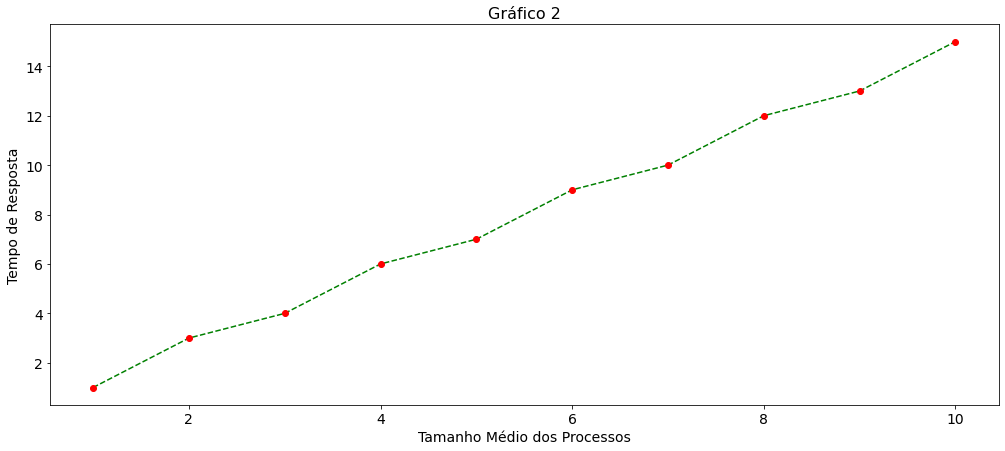

In [150]:
plt.figure(figsize=(17,7))

plt.title("Gráfico 2")
plt.ylabel("Tempo de Resposta")
plt.xlabel("Tamanho Médio dos Processos")
plt.plot(quantums,tempoRespostas,'g--')
plt.plot(quantums,tempoRespostas, 'ro')
plt.show()

In [153]:
# O pior tempo de resposta médio ocorre quando não há preempção, que pode acontecer se
#   o quantum for maior ou igual o tamanho do maior processo
def piorReposta(processo):
    tam = len(processo)
    temposResposta = np.array([0]*tam)
    for i in range(1,tam):
        temposResposta[i] = procs[i-1].tam + temposResposta[i-1] 
    return sum(temposResposta)/tam

In [154]:
procs = chamaProcs(4, ['A','B','C','D'], [0,0,0,0], np.array([10,20,30,40]))

#escalonar("round robin", procs, 2)

piorReposta(procs)

25.0